## Import Libraries

In [31]:
import os
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, transforms, models
from collections import Counter
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, GaussianBlur, Grayscale
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset, Dataset

import cv2 
from PIL import Image, ImageFilter, ImageOps
from torchvision.transforms.functional import to_pil_image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.optim import lr_scheduler

from tkinter import filedialog, Tk

# from gradcam import GradCAM, GradCAMpp
# from gradcam.utils import visualize_cam

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import dill
import torch.multiprocessing as mp

# from captum.attr import IntegratedGradients
# from captum.attr import visualization as viz

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # as M1 Mac Does not have a dedicated GPU

##### Specify the path to the locally saved dataset

In [33]:
train_data_dir = '/Users/tharanidissanayake/downloads/AugmentedAlzheimerDataset'
original_dataset = datasets.ImageFolder(train_data_dir)

In [34]:
class ContrastStretching:
    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img_np = np.array(img)
        
        # Check if the image is grayscale or RGB
        if img_np.ndim == 2:  # Grayscale image
            img_np = self.apply_contrast_stretching(img_np)
        elif img_np.ndim == 3:  # RGB image
            # Apply contrast stretching to each channel individually
            for i in range(img_np.shape[-1]):
                img_np[:, :, i] = self.apply_contrast_stretching(img_np[:, :, i])
        
        # Convert back to PIL Image
        return Image.fromarray(img_np.astype('uint8'))
    
    def apply_contrast_stretching(self, channel):
        in_min, in_max = np.percentile(channel, (0, 100))
        out_min, out_max = 0, 255
        channel = np.clip((channel - in_min) * (out_max - out_min) / (in_max - in_min) + out_min, out_min, out_max)
        return channel

class UnsharpMask:
    def __init__(self, radius=1, percent=100, threshold=3):
        self.radius = radius
        self.percent = percent
        self.threshold = threshold

    def __call__(self, img):
        return img.filter(ImageFilter.UnsharpMask(radius=self.radius, 
                                                  percent=self.percent, 
                                                  threshold=self.threshold
                                                 ))

class GaussianBlur:
    def __init__(self, kernel_size, sigma=(0.1, 2.0)):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        sigma = np.random.uniform(self.sigma[0], self.sigma[1])
        img = img.filter(ImageFilter.GaussianBlur(sigma))
        return img

#### Preprocess the dataset

In [35]:
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    ContrastStretching(),
    UnsharpMask(radius=1, percent=100, threshold=3),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
])

preprocessed_dataset = datasets.ImageFolder(root=train_data_dir, transform=preprocess_transform)

data_loader = DataLoader(preprocessed_dataset, batch_size=32, shuffle=True)

In [36]:
def calculate_psnr_ssim(original_dataset, preprocessed_dataset, num_samples=100, resize=(224, 224)):
    psnr_values = []
    ssim_values = []

    for i in range(num_samples):
        original_img = original_dataset[i][0] # original MRI
        preprocessed_img = preprocessed_dataset[i][0] # preprocessed MRI

        if not isinstance(original_img, Image.Image):
            original_img = to_pil_image(original_img)
        if not isinstance(preprocessed_img, Image.Image):
            preprocessed_img = to_pil_image(preprocessed_img)

        # Convert MRI to grayscale
        original_img = original_img.convert("L")
        preprocessed_img = preprocessed_img.convert("L")

        # Resize images
        original_img = original_img.resize(resize)
        preprocessed_img = preprocessed_img.resize(resize)

        # Convert images to numpy arrays
        original_img_np = np.array(original_img)
        preprocessed_img_np = np.array(preprocessed_img)

        # Calculate PSNR and SSIM
        psnr = peak_signal_noise_ratio(original_img_np, preprocessed_img_np, data_range=original_img_np.max() - original_img_np.min())
        ssim = structural_similarity(original_img_np, preprocessed_img_np)

        psnr_values.append(psnr)
        ssim_values.append(ssim)

    # Compute average PSNR and SSIM
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_ssim

# Example usage
avg_psnr, avg_ssim = calculate_psnr_ssim(original_dataset, preprocessed_dataset)
print(f"Average PSNR: {avg_psnr}, Average SSIM: {avg_ssim}")

Average PSNR: 27.349186492284613, Average SSIM: 0.8996168747311111


preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.Lambda(lambda x: x.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))),
    transforms.ToTensor()
)

Average PSNR: 9.729432125669954, Average SSIM: 0.2833625979364462
____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    transforms.ToTensor()
)

Average PSNR: 10.2026194786185, Average SSIM: 0.32374658927511385
____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)), 
    transforms.ToTensor(),
)

Average PSNR: 34.479706650199184, Average SSIM: 0.9638484917028203

____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1.0)), 
    transforms.ToTensor(),
)

Average PSNR: 40.03000513450271, Average SSIM: 0.9923509776637894

____________________________________________________________________
preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=2, percent=100, threshold=3))),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
)

Average PSNR: 28.919164968402907, Average SSIM: 0.9646276430637585

____________________________________________________________________
preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    ContrastStretching(),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=1, percent=100, threshold=3))),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
)

Average PSNR: 27.194490517269728, Average SSIM: 0.8948121010151182

#### MRI scan counts in each class of the dataset

In [37]:
MildDemented = '/Users/tharanidissanayake/downloads/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented = '/Users/tharanidissanayake/downloads/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented = '/Users/tharanidissanayake/downloads/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented = '/Users/tharanidissanayake/downloads/AugmentedAlzheimerDataset/VeryMildDemented'

count_MildDemented = len(os.listdir(MildDemented))
count_ModerateDemented = len(os.listdir(ModerateDemented))
count_NonDemented = len(os.listdir(NonDemented))
count_VeryMildDemented = len(os.listdir(VeryMildDemented))

print(f"Number of images in MildDemented: {count_MildDemented}")
print(f"Number of images in ModerateDemented: {count_ModerateDemented}")
print(f"Number of images in NonDemented: {count_NonDemented}")
print(f"Number of images in VeryMildDemented: {count_VeryMildDemented}")

print(f"\nTotal MRIs in the dataset = {count_MildDemented+count_ModerateDemented+count_NonDemented+count_VeryMildDemented}" )

Number of images in MildDemented: 8960
Number of images in ModerateDemented: 6464
Number of images in NonDemented: 9600
Number of images in VeryMildDemented: 8961

Total MRIs in the dataset = 33985


#### Sample MRI before and after preprocessing

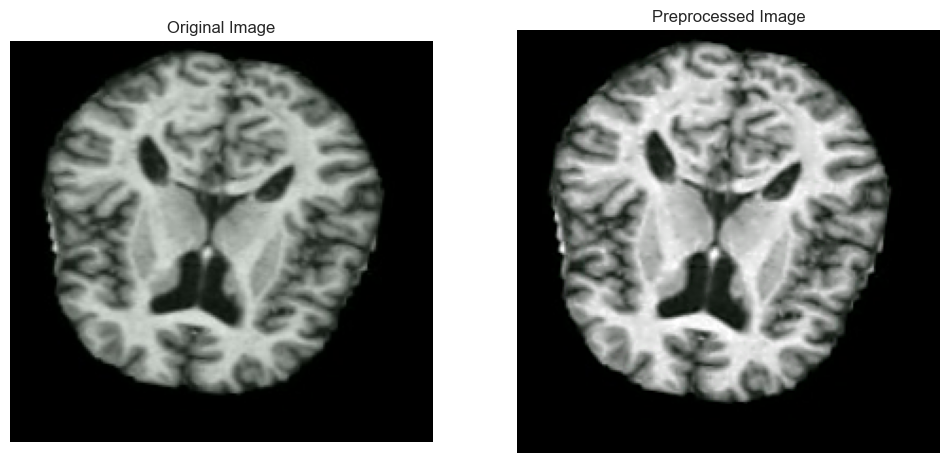

In [38]:
sample_image_path = os.path.join(MildDemented, os.listdir(MildDemented)[0])

original_image = Image.open(sample_image_path)

# Apply the preprocessing transforms
preprocessed_image = preprocess_transform(original_image)

preprocessed_image = transforms.ToPILImage()(preprocessed_image)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

### Dataset splitting & creating DataLoaders

In [39]:
train_size = int(0.70 * len(preprocessed_dataset))
val_size = int(0.15 * len(preprocessed_dataset))
test_size = len(preprocessed_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(preprocessed_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [40]:
all_labels = [label for _, label in train_dataset]
class_distribution = Counter(all_labels)
print(class_distribution)

Counter({2: 6683, 0: 6271, 3: 6263, 1: 4572})


## Building CNN

In [41]:
class CNN1(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(384)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(384 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.output = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.01)
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn6(self.conv6(x)), negative_slope=0.01)

        x = x.view(x.size(0), -1)

        x = self.dropout(F.leaky_relu(self.fc1(x), negative_slope=0.01))
        x = self.dropout(F.leaky_relu(self.fc2(x), negative_slope=0.01))
        
        x = self.output(x)

        return x

model1 = CNN1(num_classes=4)

print(model1)
summary(model1, (3,224,224))

CNN1(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_run

### Train the CNN model

Epoch 1 [train] Progress: 100%|██████████| 2974/2974 [14:50<00:00,  3.34batch/s]


train Loss: 0.8110 Acc: 0.6192


Epoch 1 [val] Progress: 100%|██████████| 638/638 [00:54<00:00, 11.67batch/s]


val Loss: 1.2649 Acc: 0.4805


Epoch 2 [train] Progress: 100%|██████████| 2974/2974 [14:42<00:00,  3.37batch/s]


train Loss: 0.4918 Acc: 0.7846


Epoch 2 [val] Progress: 100%|██████████| 638/638 [00:55<00:00, 11.45batch/s]


val Loss: 0.3721 Acc: 0.8321


Epoch 3 [train] Progress: 100%|██████████| 2974/2974 [15:01<00:00,  3.30batch/s]


train Loss: 0.3212 Acc: 0.8695


Epoch 3 [val] Progress: 100%|██████████| 638/638 [00:57<00:00, 11.19batch/s]


val Loss: 0.2701 Acc: 0.8997


Epoch 4 [train] Progress: 100%|██████████| 2974/2974 [14:43<00:00,  3.37batch/s]


train Loss: 0.2089 Acc: 0.9222


Epoch 4 [val] Progress: 100%|██████████| 638/638 [00:55<00:00, 11.53batch/s]


val Loss: 0.2119 Acc: 0.9219


Epoch 5 [train] Progress: 100%|██████████| 2974/2974 [14:32<00:00,  3.41batch/s]


train Loss: 0.1499 Acc: 0.9458


Epoch 5 [val] Progress: 100%|██████████| 638/638 [00:55<00:00, 11.49batch/s]


val Loss: 0.2607 Acc: 0.9098


Epoch 6 [train] Progress: 100%|██████████| 2974/2974 [14:33<00:00,  3.41batch/s]


train Loss: 0.1200 Acc: 0.9590


Epoch 6 [val] Progress: 100%|██████████| 638/638 [00:55<00:00, 11.51batch/s]


val Loss: 0.3741 Acc: 0.9046


Epoch 7 [train] Progress: 100%|██████████| 2974/2974 [14:36<00:00,  3.39batch/s]


train Loss: 0.0983 Acc: 0.9689


Epoch 7 [val] Progress: 100%|██████████| 638/638 [00:55<00:00, 11.46batch/s]


val Loss: 0.1301 Acc: 0.9541


Epoch 8 [train] Progress: 100%|██████████| 2974/2974 [14:41<00:00,  3.37batch/s]


train Loss: 0.0796 Acc: 0.9737


Epoch 8 [val] Progress: 100%|██████████| 638/638 [00:55<00:00, 11.45batch/s]


val Loss: 0.1718 Acc: 0.9468


Epoch 9 [train] Progress: 100%|██████████| 2974/2974 [14:44<00:00,  3.36batch/s]


train Loss: 0.0682 Acc: 0.9775


Epoch 9 [val] Progress: 100%|██████████| 638/638 [00:55<00:00, 11.40batch/s]


val Loss: 0.1219 Acc: 0.9582


Epoch 10 [train] Progress: 100%|██████████| 2974/2974 [14:35<00:00,  3.40batch/s]


train Loss: 0.0716 Acc: 0.9776


Epoch 10 [val] Progress: 100%|██████████| 638/638 [00:55<00:00, 11.45batch/s]


val Loss: 0.2086 Acc: 0.9300


Epoch 11 [train] Progress: 100%|██████████| 2974/2974 [14:37<00:00,  3.39batch/s]


train Loss: 0.0594 Acc: 0.9808


Epoch 11 [val] Progress: 100%|██████████| 638/638 [00:55<00:00, 11.54batch/s]


val Loss: 0.1027 Acc: 0.9657


Epoch 12 [train] Progress: 100%|██████████| 2974/2974 [14:40<00:00,  3.38batch/s]


train Loss: 0.0527 Acc: 0.9832


Epoch 12 [val] Progress: 100%|██████████| 638/638 [00:55<00:00, 11.44batch/s]


val Loss: 0.3714 Acc: 0.9166


Epoch 13 [train] Progress: 100%|██████████| 2974/2974 [14:39<00:00,  3.38batch/s]


train Loss: 0.0480 Acc: 0.9850


Epoch 13 [val] Progress: 100%|██████████| 638/638 [00:56<00:00, 11.35batch/s]


val Loss: 0.1610 Acc: 0.9496


Epoch 14 [train] Progress: 100%|██████████| 2974/2974 [14:39<00:00,  3.38batch/s]


train Loss: 0.0463 Acc: 0.9857


Epoch 14 [val] Progress: 100%|██████████| 638/638 [00:56<00:00, 11.39batch/s]


val Loss: 0.0787 Acc: 0.9739


Epoch 15 [train] Progress: 100%|██████████| 2974/2974 [14:37<00:00,  3.39batch/s]


train Loss: 0.0416 Acc: 0.9875


Epoch 15 [val] Progress: 100%|██████████| 638/638 [00:55<00:00, 11.42batch/s]


val Loss: 0.7424 Acc: 0.8793


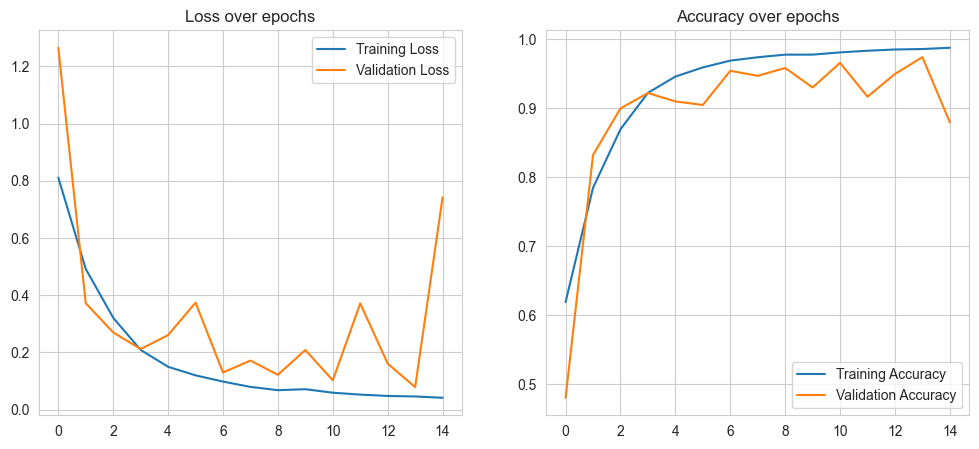

In [42]:
cnn1 = CNN1(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn1.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_epoch(epoch_index, train_loader, model, optimizer):
    model.train()  
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch_index + 1} [train] Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_pred / total_pred
    print(f'train Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

def validate_epoch(epoch_index, val_loader, model):
    model.eval() 
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch_index + 1} [val] Progress", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    avg_acc = correct_pred / total_pred
    print(f'val Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

# Training loop
num_epochs = 15
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')
patience = 8

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, train_loader, cnn1, optimizer)
    val_loss, val_acc = validate_epoch(epoch, val_loader, cnn1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(cnn1.state_dict(), 'model1_test5.pth')
    # else:
    #     trigger_times += 1
    #     if trigger_times >= patience:
    #         print(f"Early stopping at epoch {epoch+1}")
    #         break

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()

In [43]:
# Save the best model locally (model1 - modified AlexNet)

model_save_path = '/Users/tharanidissanayake/desktop' 
os.makedirs(model_save_path, exist_ok=True) 
model_save_file = os.path.join(model_save_path, 'model1_test5.pth')

torch.save(cnn1.state_dict(), model_save_file)

print(f'Model saved to {model_save_file}')

Model saved to /Users/tharanidissanayake/desktop/model1_test5.pth


In [44]:
# classification report (test loader) - modified AlexNet
model1 = CNN1(num_classes=4).to(device)

model1.load_state_dict(torch.load('model1_test5.pth'))

def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(model1, test_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.98      0.98      0.98      1306
ModerateDemented       1.00      1.00      1.00       931
     NonDemented       0.98      0.95      0.97      1486
VeryMildDemented       0.95      0.98      0.97      1376

        accuracy                           0.98      5099
       macro avg       0.98      0.98      0.98      5099
    weighted avg       0.98      0.98      0.98      5099


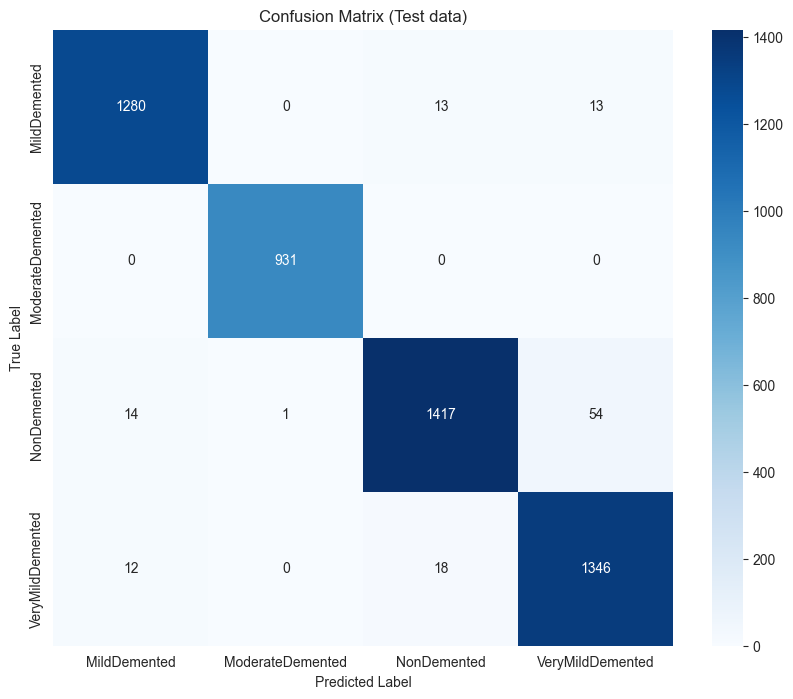

In [45]:
# Confusion Matrix on Val Loader

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(model1, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [103]:
def load_and_predict(image_path, model, transform, device, class_names):
    model.eval()
    image = Image.open(image_path)# Convert to grayscale
    image = transform(image)
    image = image.repeat(3, 1, 1)  # Repeat the single channel three times to create a 3-channel image
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

Tk().withdraw()
image_path = filedialog.askopenfilename()

if image_path:
    predicted_class = load_and_predict(image_path, model2, preprocess_transform, device, class_names)
    print(f'Predicted class: {predicted_class}')
    print(image_path)
else:
    print("No file was selected.")

2024-02-03 18:52:03.576 python[37026:2254141] +[CATransaction synchronize] called within transaction
2024-02-03 18:52:03.690 python[37026:2254141] +[CATransaction synchronize] called within transaction
2024-02-03 18:52:04.683 python[37026:2254141] +[CATransaction synchronize] called within transaction


Predicted class: Moderate Demented
/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/Test_Dataset/ModerateDemented/moderateDem49.jpg


In [107]:
# Preprocessing function
def preprocess_image(image_path):
    # Open the image file
    image = Image.open(image_path)

    # Convert the image to RGB if it is not already
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Apply the preprocessing transforms
    image_tensor = preprocess_transform(image).unsqueeze(0).to(device)

    return image_tensor, image

# Grad-CAM function
def apply_gradcam(model, image_tensor, target_layer):
    gradcam = GradCAM(model, target_layer)
    mask, _ = gradcam(image_tensor)
    heatmap, result = visualize_cam(mask, image_tensor)

    return heatmap, result

# Load and preprocess image
input_image_path = image_path
image_tensor, original_image = preprocess_image(input_image_path)

# Apply Grad-CAM (adjust target layer as needed)
target_layer = model2.classifier[-3]  # Example: last conv layer in features
heatmap, cam_result = apply_gradcam(model2, image_tensor, target_layer)

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam_result.permute(1, 2, 0).cpu().numpy())
plt.title('Grad-CAM')
plt.axis('off')

plt.show()

ValueError: not enough values to unpack (expected 4, got 2)

In [108]:
def load_and_predict(image_path, model, transform, device, class_names):
    model.eval()
    image = Image.open(image_path)# Convert to grayscale
    image = transform(image)
    image = image.repeat(3, 1, 1)  # Repeat the single channel three times to create a 3-channel image
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

Tk().withdraw()
image_path = filedialog.askopenfilename()

if image_path:
    predicted_class = load_and_predict(image_path, loaded_model, preprocess_transform, device, class_names)
    print(f'Predicted class: {predicted_class}')
    print(image_path)
else:
    print("No file was selected.")

2024-02-03 18:54:55.008 python[37026:2254141] +[CATransaction synchronize] called within transaction
2024-02-03 18:54:55.063 python[37026:2254141] +[CATransaction synchronize] called within transaction
2024-02-03 18:54:57.752 python[37026:2254141] +[CATransaction synchronize] called within transaction


Predicted class: Moderate Demented
/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/Test_Dataset/ModerateDemented/moderateDem49.jpg


/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


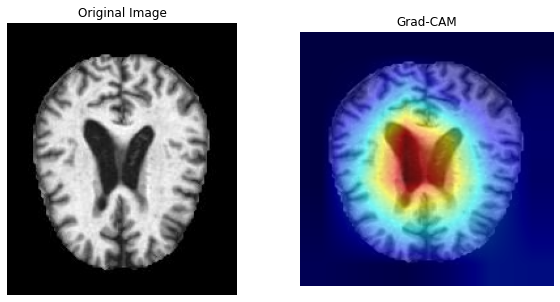

In [109]:
# Preprocessing function
def preprocess_image(image_path):
    # Open the image file
    image = Image.open(image_path)

    # Convert the image to RGB if it is not already
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Apply the preprocessing transforms
    image_tensor = preprocess_transform(image).unsqueeze(0).to(device)

    return image_tensor, image

# Grad-CAM function
def apply_gradcam(model, image_tensor, target_layer):
    gradcam = GradCAM(model, target_layer)
    mask, _ = gradcam(image_tensor)
    heatmap, result = visualize_cam(mask, image_tensor)

    return heatmap, result

# Load and preprocess image
input_image_path = image_path
image_tensor, original_image = preprocess_image(input_image_path)

# Apply Grad-CAM (adjust target layer as needed)
target_layer = loaded_model.conv6  # Example: last conv layer in features
heatmap, cam_result = apply_gradcam(loaded_model, image_tensor, target_layer)

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam_result.permute(1, 2, 0).cpu().numpy())
plt.title('Grad-CAM')
plt.axis('off')

plt.show()